# Zero shot anomaly detection on MVTec

In [1]:
import os
import math
import argparse
from tqdm import tqdm

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random

from Datasets import DATASET_REGISTRY

In [2]:
def load_dinov3_local(repo_dir, model_name, weights, device):
    """
    Load a local DINOv3 model via torch.hub (repo_dir points to the dinov3 repo).
    model_name: e.g. 'dinov3_vits16' or 'dinov3_vitl16'
    weights: path to local checkpoint
    """
    model = torch.hub.load(repo_dir, model_name, source='local', weights=weights)
    model.to(device)
    model.eval()
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dino = load_dinov3_local("dinov3", "dinov3_vits16", "dinov3_vits16_pretrain_lvd1689m-08c60483.pth", device)

In [3]:
def prepare_data_from_registry(dataset_name, category, batch_size, device, resize=512, imagesize=512, **kwargs):
    dataset_name = dataset_name.lower()
    if DATASET_REGISTRY is None:
        raise RuntimeError("DATASET_REGISTRY not available. Provide images differently.")
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    dataset_cls, split_cls, root_path = DATASET_REGISTRY[dataset_name]
    test_dataset = dataset_cls(source=root_path, split=split_cls.TEST, classname=category, resize=resize, imagesize=imagesize)
    loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    return loader

dataloader = prepare_data_from_registry("mvtec", "metal_nut", 4, device)

../mvtec_anomaly_detection/metal_nut/test


In [4]:
def get_sample_from_registry(dataset_name, category, resize=512, imagesize=512, **kwargs):
    dataset_name = dataset_name.lower()
    if DATASET_REGISTRY is None:
        raise RuntimeError("DATASET_REGISTRY not available. Provide images differently.")
    if dataset_name not in DATASET_REGISTRY:
        raise ValueError(f"Unsupported dataset: {dataset_name}")
    dataset_cls, split_cls, root_path = DATASET_REGISTRY[dataset_name]
    test_dataset = dataset_cls(source=root_path, split=split_cls.TEST, classname=category, resize=resize, imagesize=imagesize)
    idx = random.randint(0, len(test_dataset) - 1)
    sample = test_dataset[idx]   # returns dict
    return sample

test_image = get_sample_from_registry("mvtec", "metal_nut")

../mvtec_anomaly_detection/metal_nut/test


../mvtec_anomaly_detection/metal_nut/test


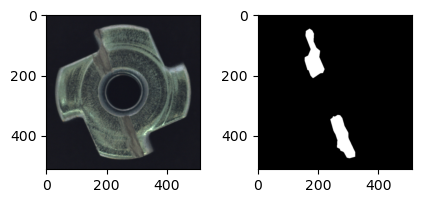

In [8]:
test_image = get_sample_from_registry("mvtec", "metal_nut")

fig, ax = plt.subplots(1,2, figsize=(5,2))

image = test_image['image']
mask = test_image['mask']

ax[0].imshow(image.permute(1,2,0).cpu())
ax[1].imshow(mask.squeeze().cpu(), cmap='gray')
plt.show()

../mvtec_anomaly_detection/metal_nut/test
../mvtec_anomaly_detection/metal_nut/test
../mvtec_anomaly_detection/metal_nut/test
../mvtec_anomaly_detection/metal_nut/test
../mvtec_anomaly_detection/metal_nut/test


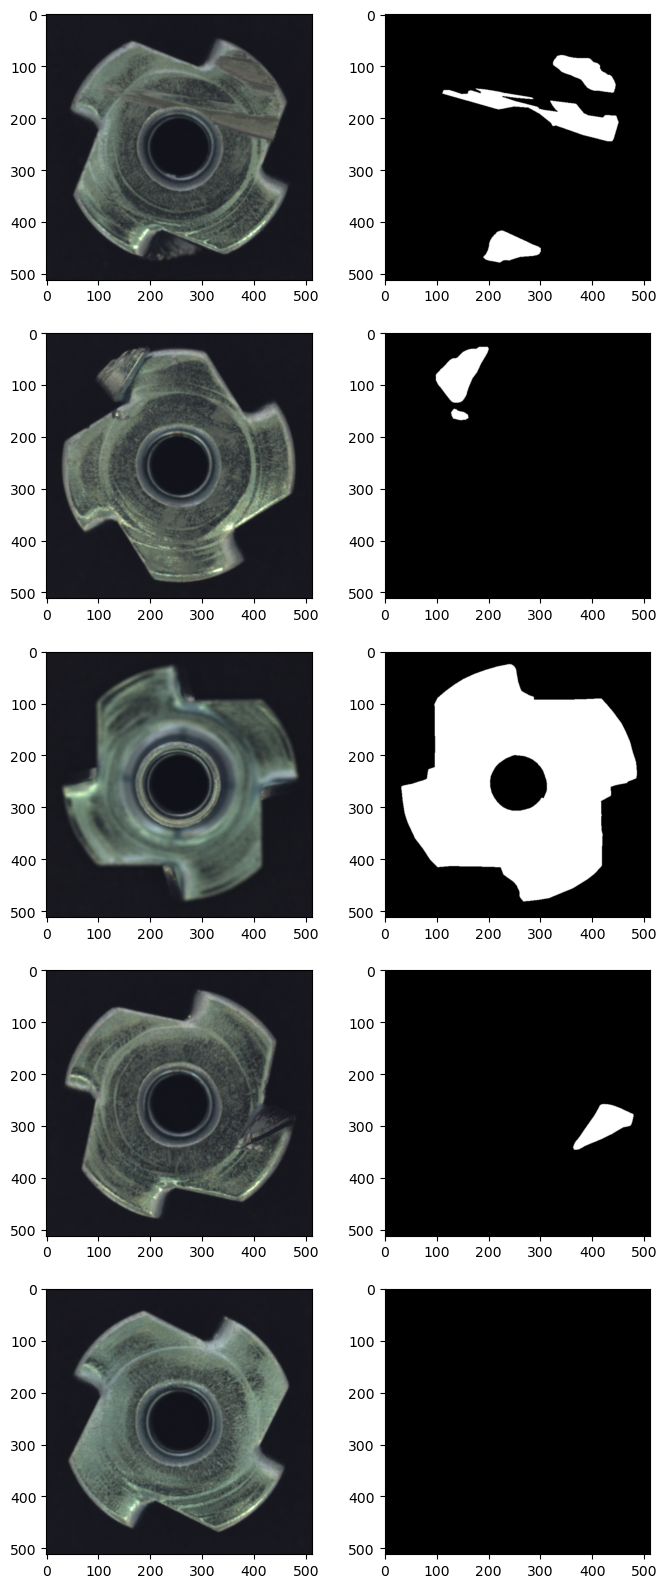

In [10]:
fig, ax = plt.subplots(5,2, figsize=(8,20))

for i in range(5):

    sample = get_sample_from_registry("mvtec", "metal_nut")
    batch = {'image': sample['image'].unsqueeze(0), 'mask': sample['mask'].unsqueeze(0)}
    image = batch['image']
    mask = batch['mask']

    ax[i,0].imshow(image[0].permute(1,2,0).cpu())
    ax[i,1].imshow(mask[0].squeeze().cpu(), cmap='gray')

plt.show()

In [9]:
all_labels = []
all_embeddings = []
torch.cuda.empty_cache()
Dino.eval()
for batch in tqdm(dataloader):
    data = batch['image']
    labels = batch['mask']
    new_labels = labels.numpy().tolist()
    all_labels += new_labels
    data = data.to(device)
    embeddings = Dino(data.to(device))
    all_embeddings.append(np.reshape(embeddings.detach().cpu().numpy(),(len(new_labels),-1)))
all_embeddings = np.vstack(all_embeddings)

100%|██████████| 29/29 [00:39<00:00,  1.38s/it]


In [10]:
all_embeddings[0].shape

(384,)